In [1]:
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import seaborn as sns
import prince
import sklearn

from sklearn.base import BaseEstimator,TransformerMixin, ClassifierMixin
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, RobustScaler, OneHotEncoder, PolynomialFeatures, StandardScaler, SplineTransformer, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, f1_score, roc_curve, auc, recall_score, precision_recall_curve, make_scorer, ConfusionMatrixDisplay,confusion_matrix
from sklearn.kernel_approximation import Nystroem
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.decomposition import PCA
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from imblearn.metrics import classification_report_imbalanced

from prince import FAMD

from scipy.stats import chi2_contingency

from yellowbrick.classifier import DiscriminationThreshold


import joblib

In [2]:
file = open('../../../conf/global_conf.yml', 'r') 
conf = yaml.safe_load(file)
df = pd.read_csv(conf['local_data_path'] + "data_cleaned_final_sans_dummies.csv",index_col=0,low_memory=False)

In [3]:
print(df.shape)

(447136, 41)


In [4]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.1.post1.


In [4]:
# Recodage variable cible grav par ordre croissant : 0 : indemne, 1 : blessé léger, 2 : blessé grave, 3 : décès
with pd.option_context("future.no_silent_downcasting", True):
    df['grav'] = df['grav'].replace(1,'I')
    df['grav'] = df['grav'].replace(2,'T')
    df['grav'] = df['grav'].replace(3,'BG')
    df['grav'] = df['grav'].replace(4,'BL')
    df['grav'] = df['grav'].replace('I',0)
    df['grav'] = df['grav'].replace('T',3)
    df['grav'] = df['grav'].replace('BG',2)
    df['grav'] = df['grav'].replace('BL',1)

In [5]:
data = df.drop(['grav_rec', 'an', 'jour', 'date', 'grav', 'dep'], axis=1)
y = df.grav.astype('int')
numerical_features = ['age_usager', 'mois', 'heure', 'lat', 'long']
categorical_features = [col for col in data.columns if col not in numerical_features]
data[categorical_features] = data[categorical_features].astype('object')
#data.info()

In [7]:
data.iloc[:2,20:]

,motor,weekend,heure,place_rec,age_usager,eq_ceinture,eq_casque,eq_siege,eq_gilet,eq_airbag,eq_gants,eq_indetermine,eq_autre,jour_chome,prox_pt_choc
0,1.0,1,1,2.0,17.0,1,0,0,0,0,0,0,0,1,0
1,1.0,1,1,1.0,26.0,1,0,0,0,0,0,0,0,1,0


In [6]:
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42, stratify=y)

In [7]:
data_test.dtypes

mois                int64
lum                object
agg                object
int                object
atm                object
col                object
lat               float64
long              float64
catr               object
circ               object
prof               object
plan               object
surf               object
infra              object
situ               object
sexe               object
catv               object
obs                object
obsm               object
manv               object
motor              object
weekend            object
heure               int64
place_rec          object
age_usager        float64
eq_ceinture        object
eq_casque          object
eq_siege           object
eq_gilet           object
eq_airbag          object
eq_gants           object
eq_indetermine     object
eq_autre           object
jour_chome         object
prox_pt_choc       object
dtype: object

In [8]:
class TransfoHour(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo[f'{self.column_name}_cos'] = np.cos(X_transfo[self.column_name]*(2.*np.pi/24))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo
    
    def get_feature_names_out(self):
        pass
    
class TransfoMonth(BaseEstimator, TransformerMixin):
    def __init__(self, column_name):
        self.column_name = column_name
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_transfo = X.copy()
        X_transfo[f'{self.column_name}_sin'] = np.sin((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo[f'{self.column_name}_cos'] = np.cos((X_transfo[self.column_name]-1)*(2.*np.pi/12))
        X_transfo = X_transfo.drop(self.column_name, axis=1)
        return X_transfo

    def get_feature_names_out(self):
        pass
    

In [9]:
preprocessor = ColumnTransformer(transformers=[
    ("transfo_heure", TransfoHour('heure'), ['heure']),
    ("transfo_mois", TransfoMonth('mois'), ['mois']),
    ("transfo_lat_long", RobustScaler(), ['lat', 'long']),
    ('transfo_age_usager', MinMaxScaler(), ['age_usager']),
    ("one_hot_encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['place_rec','catr', 'surf', 'infra', 'situ', 'motor', 'manv', 'obsm', 'catv', 'col', 'lum'])
    ],
    remainder="passthrough"
).set_output(transform="pandas")

logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])

In [12]:
logistic_regression

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transfo_heure',
                                                  TransfoHour(column_name='heure'),
                                                  ['heure']),
                                                 ('transfo_mois',
                                                  TransfoMonth(column_name='mois'),
                                                  ['mois']),
                                                 ('transfo_lat_long',
                                                  RobustScaler(),
                                                  ['lat', 'long']),
                                                 ('transfo_age_usager',
                                                  MinMaxScaler(),
                                                  ['age_usager']),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['place_rec', 'catr', 'surf',
                                                   'infra', 'situ', 'motor',
                                                   'manv', 'obsm', 'catv',
                                                   'col', 'lum'])])),
                ('log_reg',
                 LogisticRegression(class_weight='balanced', max_iter=5000,
                                    multi_class='ovr'))])

In [13]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.600, test=0.605) total time= 1.2min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s


[CV] END ..................., score=(train=0.601, test=0.597) total time= 1.3min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


[CV] END ..................., score=(train=0.601, test=0.594) total time= 1.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.0min finished


,fit_time,score_time,estimator,test_score,train_score
0,70.891395,2.050667,"(ColumnTransformer(remainder='passthrough',\n ...",0.605377,0.599772
1,76.427392,1.580637,"(ColumnTransformer(remainder='passthrough',\n ...",0.597336,0.600931
2,74.107001,1.722621,"(ColumnTransformer(remainder='passthrough',\n ...",0.594384,0.601498


In [14]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])
logistic_regression.fit(data_train, y_train)
y_pred = logistic_regression.predict(data_test)
cr = classification_report(y_test, y_pred)
print(cr)
pd.crosstab(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.71      0.81      0.76     46137
           1       0.68      0.48      0.56     45097
           2       0.41      0.40      0.41     17500
           3       0.13      0.45      0.20      3050

    accuracy                           0.60    111784
   macro avg       0.48      0.54      0.48    111784
weighted avg       0.64      0.60      0.61    111784



col_0,0,1,2,3
grav,,,,
0,37237,4836,2055,2009
1,13037,21571,6953,3536
2,1923,4932,7077,3568
3,256,392,1019,1383


**Ajout d'un undersampler**

In [13]:
logistic_regression = Pipeline(steps=[("undersampler", RandomUnderSampler(sampling_strategy="auto")),
                                      ("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='ovr', class_weight='balanced'))])

In [14]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[CV] START .....................................................................
[CV] END ..................., score=(train=0.566, test=0.573) total time=   7.6s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:   11.4s


[CV] END ..................., score=(train=0.565, test=0.561) total time=   8.7s
[CV] START .....................................................................
[CV] END ..................., score=(train=0.569, test=0.563) total time=   8.0s


,fit_time,score_time,estimator,test_score,train_score
0,6.053255,1.654963,"(RandomUnderSampler(), ColumnTransformer(remai...",0.573427,0.566396
1,7.101858,1.660915,"(RandomUnderSampler(), ColumnTransformer(remai...",0.561186,0.565482
2,6.365251,1.688710,"(RandomUnderSampler(), ColumnTransformer(remai...",0.563078,0.569467


Pas d'undersampler

**Hyperparameter tuning**

Analyse de l'influence du type de pénalisation (L1 ou L2), du paramètre contrôlant la régularisation, et du type d'approche (one-vs-rest ou multiclass)
Le changement de pénalisation nécessite un changement de solveur. 

In [70]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, class_weight='balanced', random_state=1234))])
param_grid =[{"log_reg__solver": ['liblinear'],"log_reg__penalty": ['l1'], "log_reg__C" : [10**(i) for i in range(-2,2)], "log_reg__multi_class" : ['auto', 'ovr']},
             {"log_reg__solver": ['newton-cg'],"log_reg__penalty": ['l2'], "log_reg__C" : [1], "log_reg__multi_class" : ['auto', 'ovr']}]

f1 = make_scorer(f1_score, average='micro')
model_gds = GridSearchCV(logistic_regression,
                                         param_grid=param_grid,
                                         scoring=f1,                                
                                         cv=2,
                                         return_train_score=True,
                                         verbose=10)
model_gds.fit(data_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV 1/2; 1/10] START log_reg__C=0.01, log_reg__multi_class=auto, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 1/2; 1/10] END log_reg__C=0.01, log_reg__multi_class=auto, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.617, test=0.618) total time=  24.5s
[CV 2/2; 1/10] START log_reg__C=0.01, log_reg__multi_class=auto, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 2/2; 1/10] END log_reg__C=0.01, log_reg__multi_class=auto, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.620, test=0.618) total time=  24.7s
[CV 1/2; 2/10] START log_reg__C=0.01, log_reg__multi_class=ovr, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 1/2; 2/10] END log_reg__C=0.01, log_reg__multi_class=ovr, log_reg__penalty=l1, log_reg__solver=liblinear;, score=(train=0.617, test=0.618) total time=  24.9s
[CV 2/2; 2/10] START log_reg__C=0.01, log_reg__multi_class=ovr, log_reg__penalty=l1, log_reg__solver=liblinear
[CV 2

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('transfo_heure',
                                                                         TransfoHour(column_name='heure'),
                                                                         ['heure']),
                                                                        ('transfo_mois',
                                                                         TransfoMonth(column_name='mois'),
                                                                         ['mois']),
                                                                        ('transfo_lat_long',
                                                                         RobustScaler(),
                                                                         ['lat',
                                                                          'long']),
                                                                        ('transfo_age_usager',
                                                                         MinMaxScaler(),
                                                                         ['age_usager']),
                                                                        ('one_hot_...
             param_grid=[{'log_reg__C': [0.01, 0.1, 1, 10],
                          'log_reg__multi_class': ['auto', 'ovr'],
                          'log_reg__penalty': ['l1'],
                          'log_reg__solver': ['liblinear']},
                         {'log_reg__C': [1],
                          'log_reg__multi_class': ['auto', 'ovr'],
                          'log_reg__penalty': ['l2'],
                          'log_reg__solver': ['newton-cg']}],
             return_train_score=True,
             scoring=make_scorer(f1_score, response_method='predict', average=micro),
             verbose=10)

In [71]:
cv_results = pd.DataFrame(model_gds.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_log_reg__C,param_log_reg__multi_class,param_log_reg__penalty,param_log_reg__solver,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,22.342634,0.176944,2.377859,0.049371,0.01,auto,l1,liblinear,"{'log_reg__C': 0.01, 'log_reg__multi_class': '...",0.618109,0.617691,0.617900,0.000209,7,0.617459,0.619880,0.618669,0.001211
1,22.774902,0.374311,2.488839,0.124928,0.01,ovr,l1,liblinear,"{'log_reg__C': 0.01, 'log_reg__multi_class': '...",0.618109,0.617691,0.617900,0.000209,7,0.617459,0.619880,0.618669,0.001211
2,99.351320,22.533772,2.391428,0.005734,0.1,auto,l1,liblinear,"{'log_reg__C': 0.1, 'log_reg__multi_class': 'a...",0.620715,0.619522,0.620119,0.000596,5,0.620411,0.621878,0.621144,0.000734
3,91.933268,18.478848,2.348312,0.005561,0.1,ovr,l1,liblinear,"{'log_reg__C': 0.1, 'log_reg__multi_class': 'o...",0.620715,0.619522,0.620119,0.000596,5,0.620411,0.621878,0.621144,0.000734
4,147.105881,33.949050,2.478147,0.156132,1,auto,l1,liblinear,"{'log_reg__C': 1, 'log_reg__multi_class': 'aut...",0.621067,0.619415,0.620241,0.000826,1,0.620351,0.621854,0.621103,0.000751
5,149.386555,36.339669,2.428576,0.111269,1,ovr,l1,liblinear,"{'log_reg__C': 1, 'log_reg__multi_class': 'ovr...",0.621067,0.619415,0.620241,0.000826,1,0.620351,0.621854,0.621103,0.000751
6,59.365979,48.943746,2.381477,0.049160,10,auto,l1,liblinear,"{'log_reg__C': 10, 'log_reg__multi_class': 'au...",0.621043,0.619254,0.620148,0.000895,3,0.620411,0.621729,0.621070,0.000659
7,57.886793,47.878939,2.374766,0.025003,10,ovr,l1,liblinear,"{'log_reg__C': 10, 'log_reg__multi_class': 'ov...",0.621043,0.619254,0.620148,0.000895,3,0.620411,0.621729,0.621070,0.000659
8,18.161111,1.750830,2.377120,0.091809,1,auto,l2,newton-cg,"{'log_reg__C': 1, 'log_reg__multi_class': 'aut...",0.570672,0.570905,0.570788,0.000116,10,0.571865,0.572557,0.572211,0.000346
9,13.575491,0.588455,2.325235,0.064079,1,ovr,l2,newton-cg,"{'log_reg__C': 1, 'log_reg__multi_class': 'ovr...",0.599096,0.599651,0.599373,0.000277,9,0.599299,0.601320,0.600310,0.001011


In [72]:
model_gds.best_params_

{'log_reg__C': 1,
 'log_reg__multi_class': 'auto',
 'log_reg__penalty': 'l1',
 'log_reg__solver': 'liblinear'}

Sauvegarde du meilleur modèle

In [76]:
filename = conf['local_data_path'] + 'logreg_model'
joblib.dump(model_gds.best_estimator_, filename)

['C:/Users/dcons/Documents/NADEGE/DATASCIENTEST/Projet/data/logreg_model']

In [10]:
#Si besoin de recharger le modèle
filename = conf['local_data_path'] + 'logreg_model'
logreg = joblib.load(filename)

Analyse des prédictions avec le meilleur modèle

In [15]:
score_train = logreg.score(data_train, y_train)
score_test = logreg.score(data_test, y_test)

In [16]:
print(f"Le score sur le jeu d'entraînement est de {score_train}, et de {score_test} sur le jeu de test.")

Le score sur le jeu d'entraînement est de 0.6205777809585152, et de 0.6224504401345452 sur le jeu de test.


In [17]:
y_pred_best_est = logreg.predict(data_test)
cr= classification_report(y_test, y_pred_best_est, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'])
print(cr)

                precision    recall  f1-score   support

      Indemnes       0.70      0.82      0.76     46137
Blessés légers       0.66      0.54      0.59     45097
Blessés graves       0.45      0.36      0.40     17500
          Tués       0.16      0.37      0.22      3050

      accuracy                           0.62    111784
     macro avg       0.49      0.52      0.49    111784
  weighted avg       0.63      0.62      0.62    111784



In [79]:
y_pred_best_est = logreg.predict(data_test)
cr= classification_report(y_test, y_pred_best_est, target_names=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()
print(df_cr)
df_cr.to_csv(conf['local_data_path'] + 'logreg_report' + '.csv')

                precision    recall  f1-score       support
Indemnes         0.701256  0.820556  0.756230   46137.00000
Blessés légers   0.663724  0.538462  0.594567   45097.00000
Blessés graves   0.451534  0.359886  0.400534   17500.00000
Tués             0.157076  0.374098  0.221253    3050.00000
accuracy         0.622450  0.622450  0.622450       0.62245
macro avg        0.493397  0.523250  0.493146  111784.00000
weighted avg     0.632172  0.622450  0.620729  111784.00000


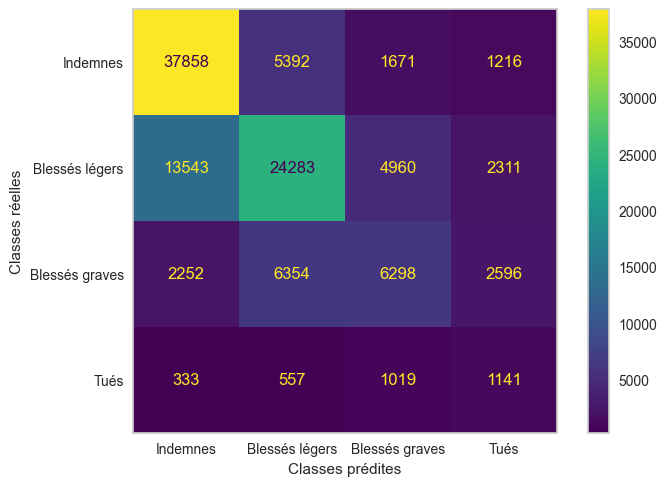

In [80]:
cm = confusion_matrix(y_test, y_pred_best_est)
disp = ConfusionMatrixDisplay.from_estimator(
        logreg,
        data_test,
        y_test,
        display_labels=['Indemnes', 'Blessés légers', 'Blessés graves', 'Tués']
    )
disp.ax_.set(xlabel='Classes prédites', ylabel='Classes réelles')
plt.grid(False)
plt.savefig(conf['local_data_path'] + 'logreg_confusion_matrix' + '.jpg')


**Interprétabilité**

*Analyse des coefficients de la régression logistique*

In [26]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='auto', class_weight='balanced',
                                                                     solver='liblinear', C=1, penalty='l1'))])

In [27]:
f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
cv_results

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] START .....................................................................
[CV] END ..................., score=(train=0.620, test=0.624) total time= 4.0min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s


[CV] END ..................., score=(train=0.622, test=0.619) total time= 8.6min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.8min remaining:    0.0s


[CV] END ..................., score=(train=0.622, test=0.616) total time=10.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 23.8min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 23.8min finished


,fit_time,score_time,estimator,test_score,train_score
0,239.238144,2.382555,"(ColumnTransformer(remainder='passthrough',\n ...",0.624156,0.620252
1,513.680567,1.922512,"(ColumnTransformer(remainder='passthrough',\n ...",0.618974,0.621716
2,654.052156,1.756862,"(ColumnTransformer(remainder='passthrough',\n ...",0.615908,0.622437


In [13]:
data_preproc = preprocessor.fit_transform(data_train, y_train)

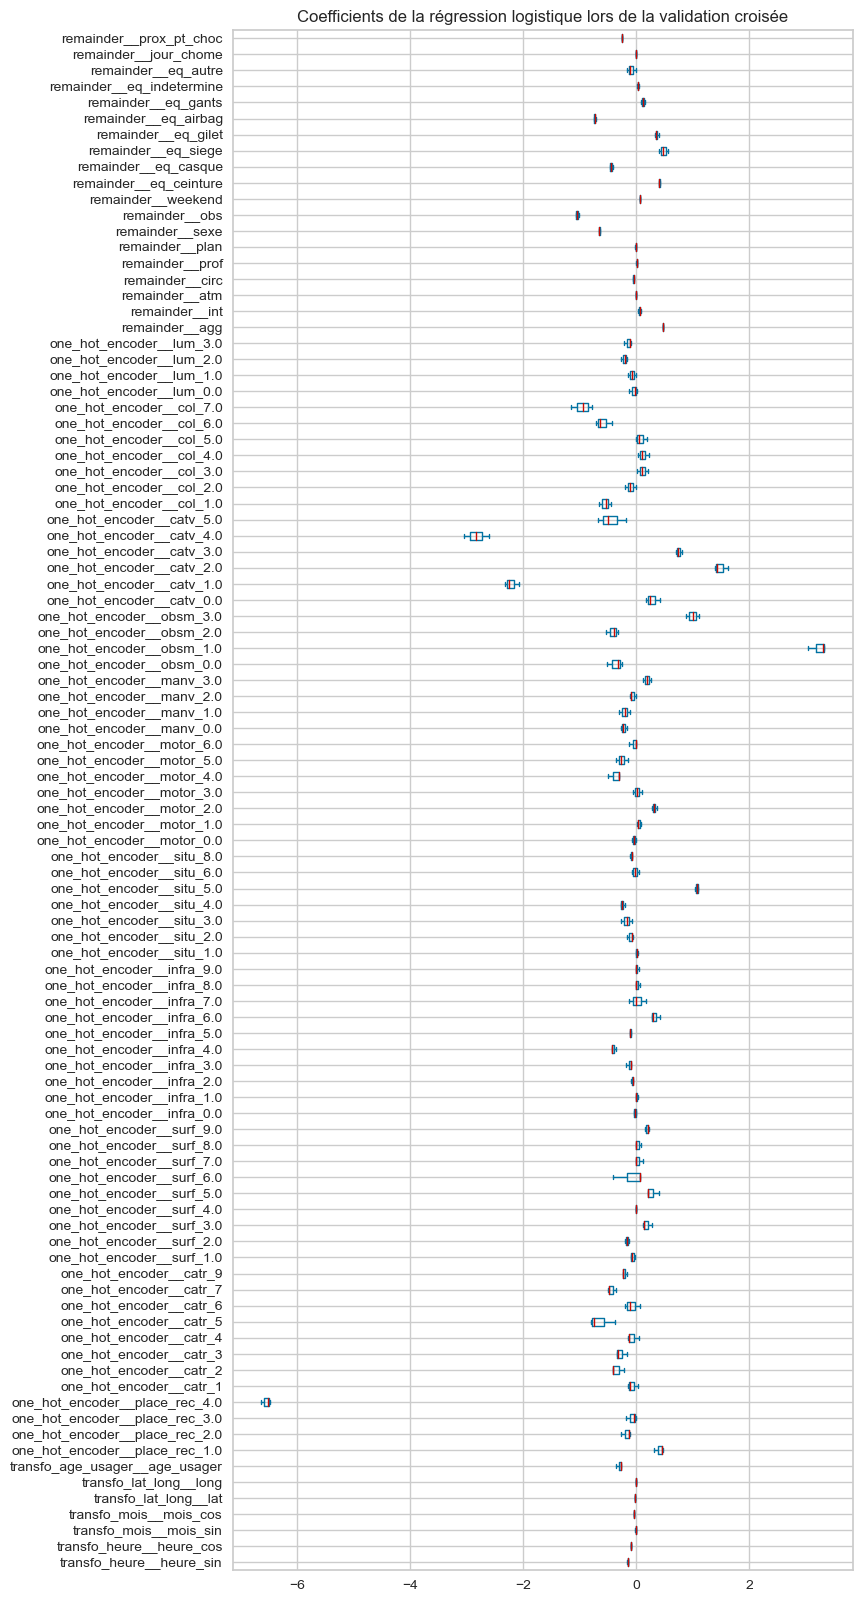

In [29]:
coefs = [est[-1].coef_[0] for est in cv_results["estimator"]]
weights_logreg = pd.DataFrame(coefs, columns = data_preproc.columns)

fig, ax = plt.subplots(figsize=(8,20));
weights_logreg.plot.box(vert=False, ax=ax);
plt.title('Coefficients de la régression logistique lors de la validation croisée');
plt.savefig(conf['local_data_path'] + 'logreg_coefficients' + '.jpg')

In [12]:
logistic_regression = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("log_reg", LogisticRegression(max_iter=5000, multi_class='auto', class_weight='balanced',
                                                                     solver='liblinear', C=1, penalty='l1'))])

f1 = make_scorer(f1_score, average='micro')
cv_results = cross_validate(logistic_regression, data, y, cv=3, 
                            return_estimator=True, return_train_score=True, scoring=f1,
                            verbose=10)
cv_results = pd.DataFrame(cv_results)
#cv_results


[CV] START .....................................................................
[CV] END ..................., score=(train=0.620, test=0.624) total time= 4.7min
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  4.8min


[CV] END ..................., score=(train=0.622, test=0.619) total time= 6.7min
[CV] START .....................................................................
[CV] END ..................., score=(train=0.622, test=0.616) total time= 5.9min


NameError: name 'data_preproc' is not defined

In [18]:
coefsabs = [np.abs(est[-1].coef_[0]) for est in cv_results["estimator"]]
abs_weights_logreg = pd.DataFrame(coefsabs, columns = data_preproc.columns).mean().sort_values(ascending=False)
abs_weights_logreg

one_hot_encoder__place_rec_4.0    6.837494
one_hot_encoder__obsm_1.0         3.392765
one_hot_encoder__catv_4.0         2.823924
one_hot_encoder__catv_1.0         2.202679
one_hot_encoder__catv_2.0         1.491211
                                    ...   
transfo_mois__mois_sin            0.008505
remainder__plan                   0.007528
transfo_lat_long__long            0.005685
remainder__atm                    0.004207
remainder__jour_chome             0.002868
Length: 96, dtype: float64

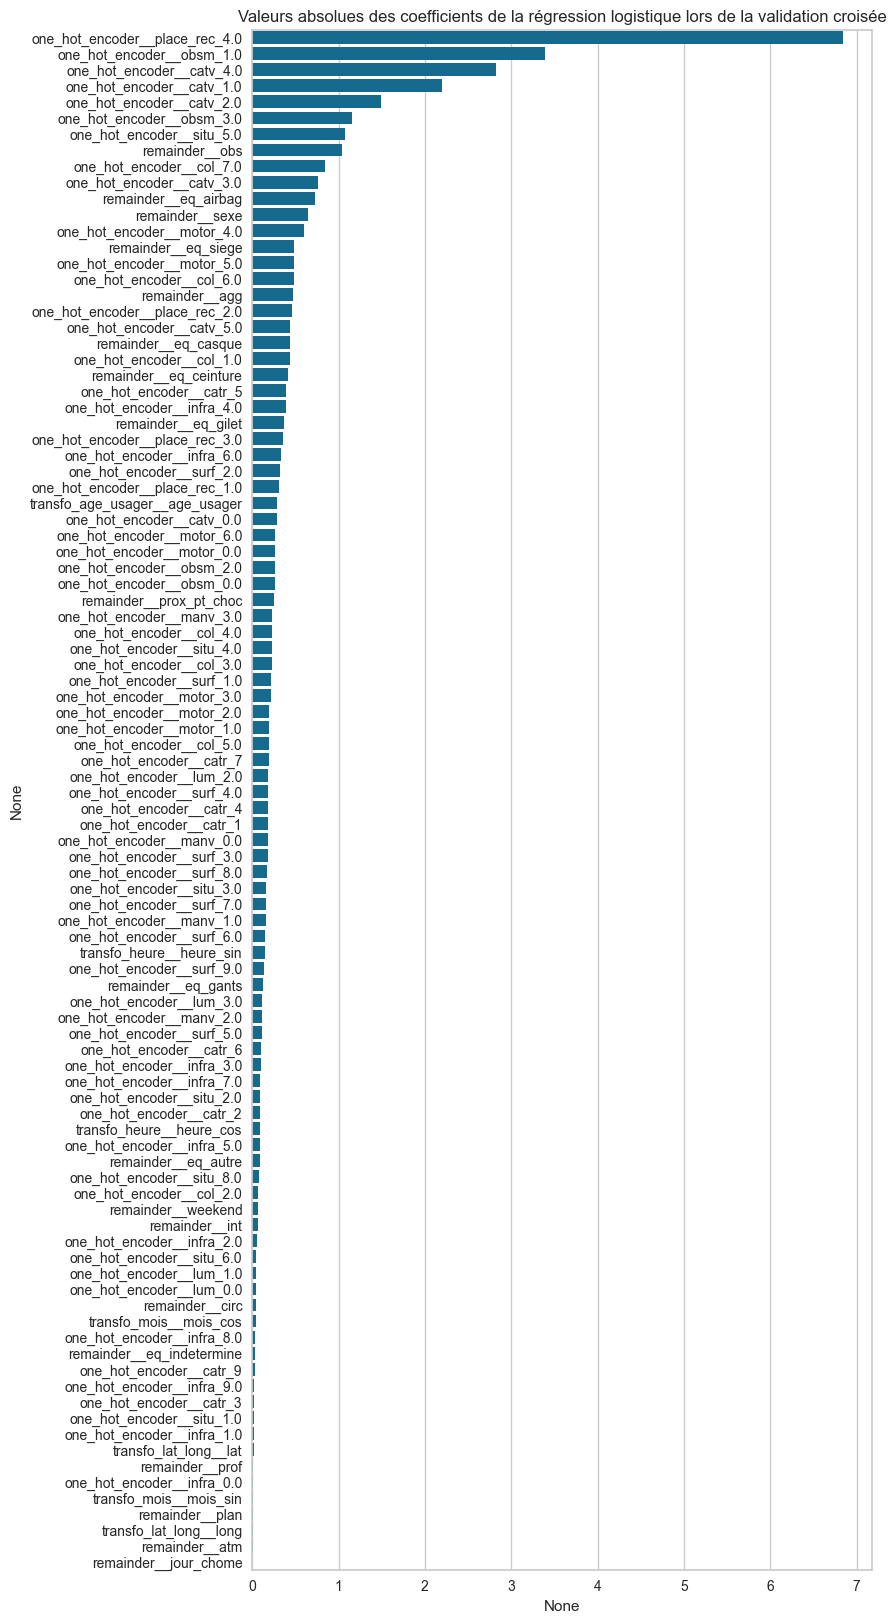

In [24]:
fig, ax = plt.subplots(figsize=(8,20));
sns.barplot(x=abs_weights_logreg, y=abs_weights_logreg.index)
plt.title('Valeurs absolues des coefficients de la régression logistique lors de la validation croisée');
#plt.savefig(conf['local_data_path'] + 'logreg_coefficients' + '.jpg')

*Analyse factorielle*

In [30]:

famd = FAMD(n_components=data_preproc.columns.shape[0])
essai_famd = famd.fit(data_preproc)

<Axes: >

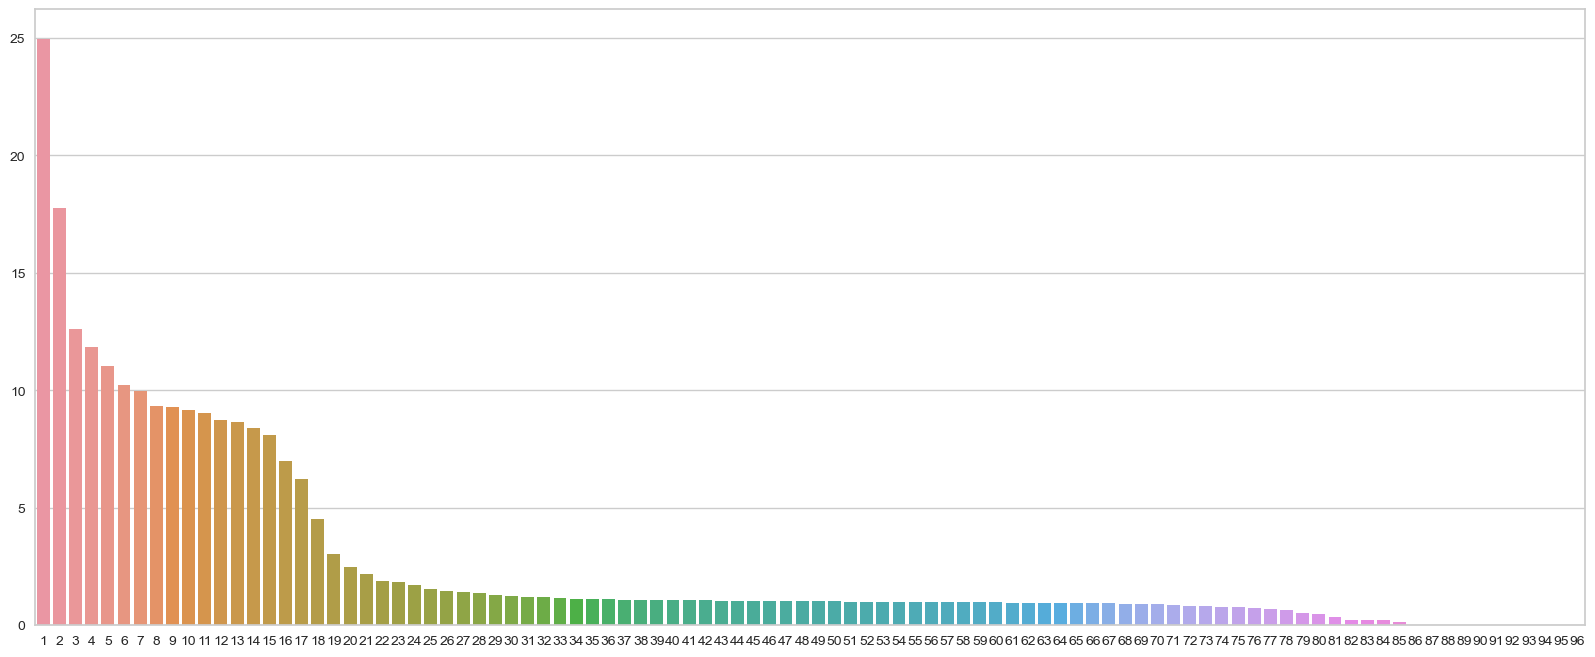

In [31]:
figure = plt.figure(figsize=(20,8))
sns.barplot(x=np.arange(1,data_preproc.shape[1]+1), y=famd.eigenvalues_)

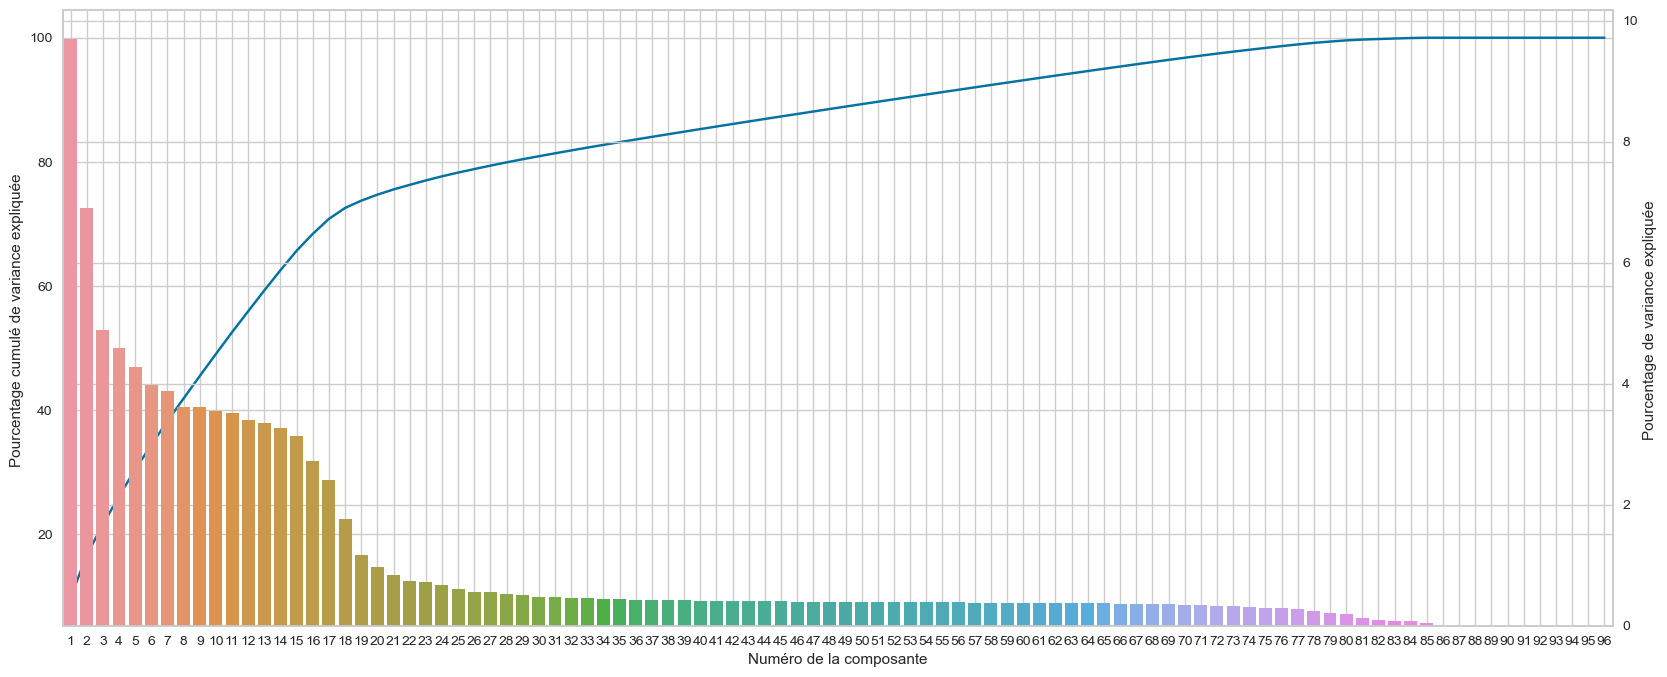

In [32]:
figure = plt.figure(figsize=(20,8))
ax = figure.add_subplot(111)
ax.plot(famd.cumulative_percentage_of_variance_);
ax.set_xlabel("Numéro de la composante");
ax.set_ylabel("Pourcentage cumulé de variance expliquée ");

ax2 = ax.twinx()
sns.barplot(x=np.arange(1,data_preproc.shape[1]+1),y=famd.percentage_of_variance_, ax=ax2)
ax2.set_ylabel("Pourcentage de variance expliquée ");
plt.savefig(conf['local_data_path'] + 'famd_var_explain' + '.jpg')


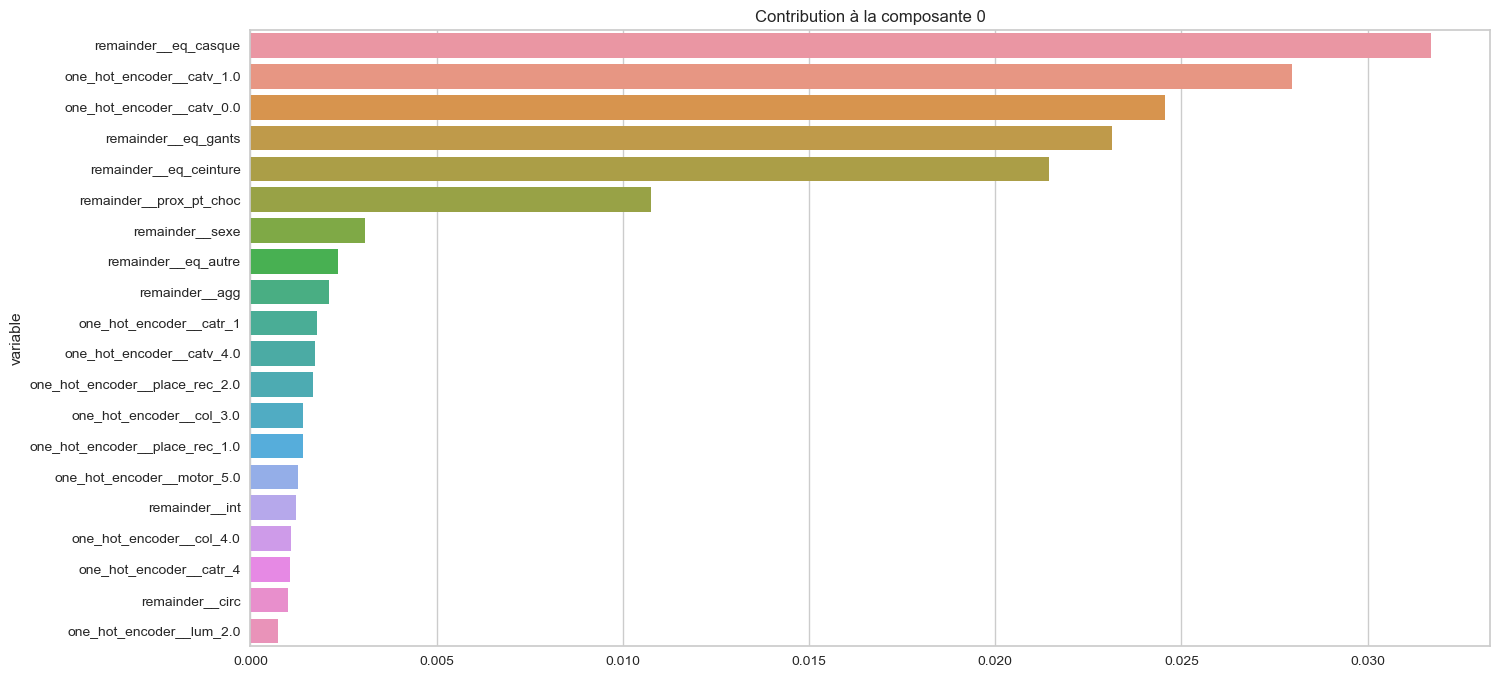

In [33]:
comp_ret = 0
df = essai_famd.column_contributions_.iloc[:,comp_ret].sort_values(ascending=False)
plt.figure(figsize=(16,8));
plt.title(f'Contribution à la composante {comp_ret}');
sns.barplot(y=df.index[:20],x=df.values[:20]);
plt.savefig(conf['local_data_path'] + 'famd_comp0' + '.jpg')

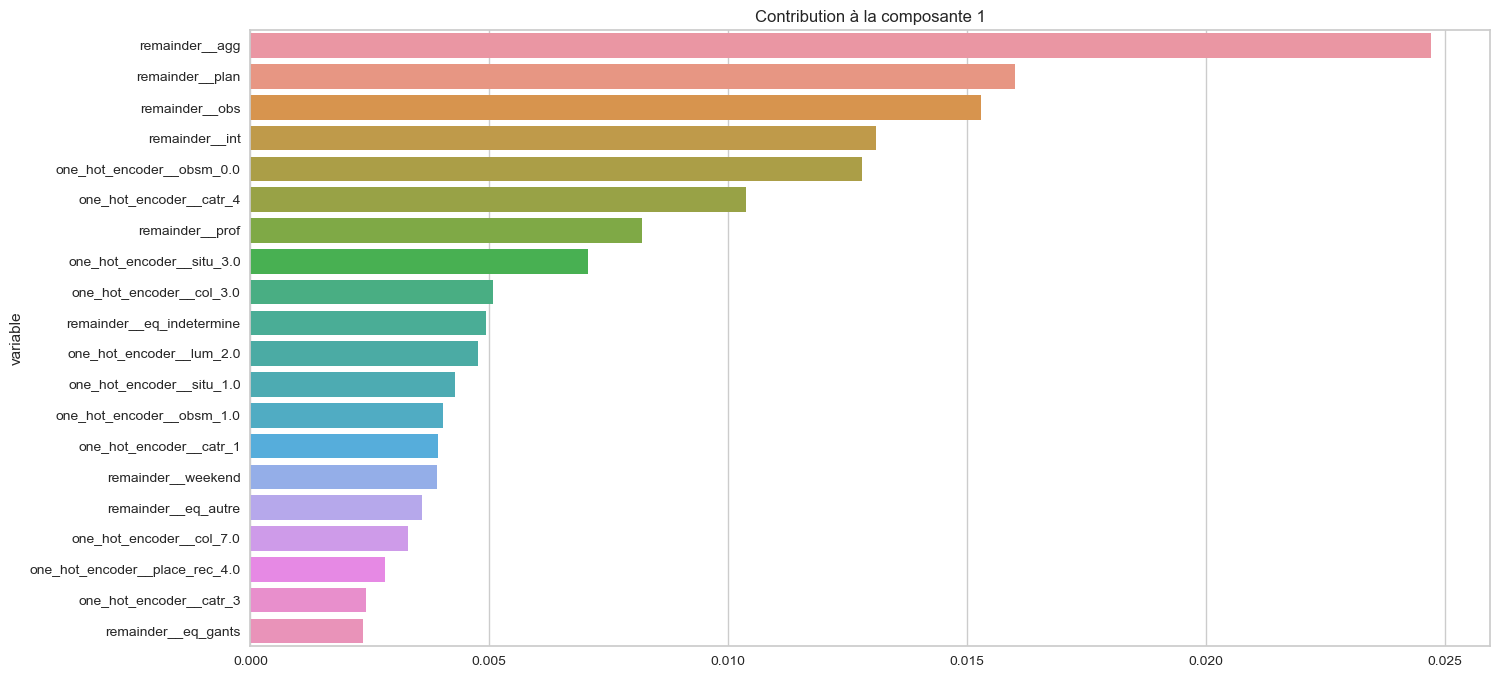

In [34]:
comp_ret = 1
df = essai_famd.column_contributions_.iloc[:,comp_ret].sort_values(ascending=False)
plt.figure(figsize=(16,8));
plt.title(f'Contribution à la composante {comp_ret}');
sns.barplot(y=df.index[:20],x=df.values[:20]);
plt.savefig(conf['local_data_path'] + 'famd_comp1' + '.jpg')